###### <img src="./logo_UTN.svg" align="right" width="150" /> 

### Procesamiento Digital de Señales

## Trabajo Práctico Nº7: Primeras nociones de estimación espectral: Ancho de banda de señales

### Gabriel Cruz

En el repositorio PDStestbench encontrará tres tipos de señales registradas:

- Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
- Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
- Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide realizar una estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase.

Bonus:

- 💎 Compare el método que haya elegido con los demás vistos: Periodograma ventaneado, Welch, Blackman-Tukey.
- 🤯  Realice una estimación del ancho de banda de cada señal

In [103]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

from scipy import signal
from scipy.fft import fft, fftshift

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

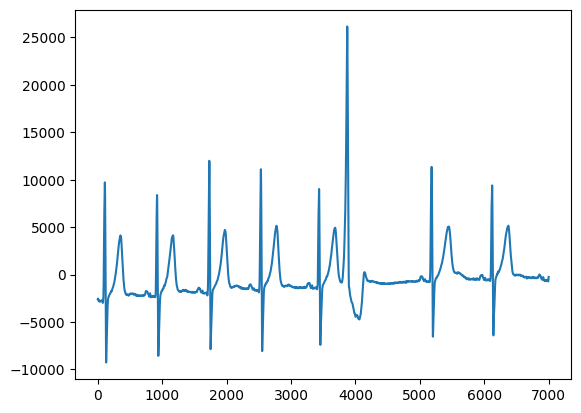

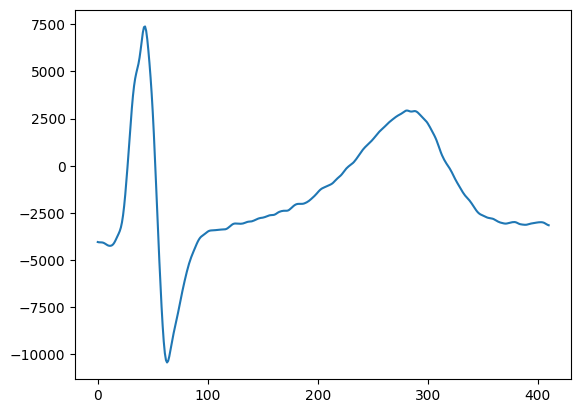

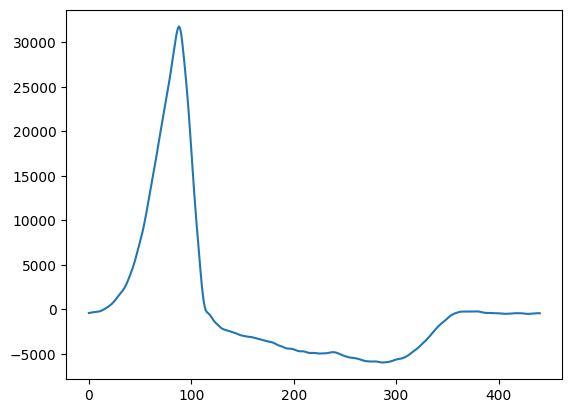

In [104]:
#%% Señales a analizar 

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
N = len(ecg_one_lead)

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])

plt.figure()
plt.plot(ecg_one_lead[5000:12000])

plt.figure()
plt.plot(hb_1)

plt.figure()
plt.plot(hb_2)

En el grafico de arriba podemos observar la señal Electrocardiograma (ECG).

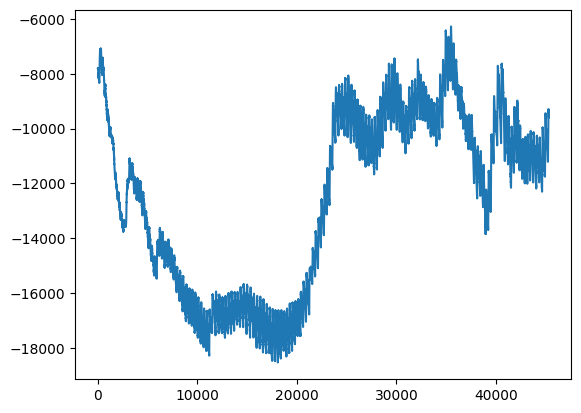

In [105]:
####################################
# Lectura de pletismografía (PPG)  #
####################################

fs_ppg = 400 # Hz

# Cargar el archivo CSV como un array de NumPy
ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe

plt.figure()
plt.plot(ppg)


En el grafico de arriba podemos observar la señal pletismografía (PPG).

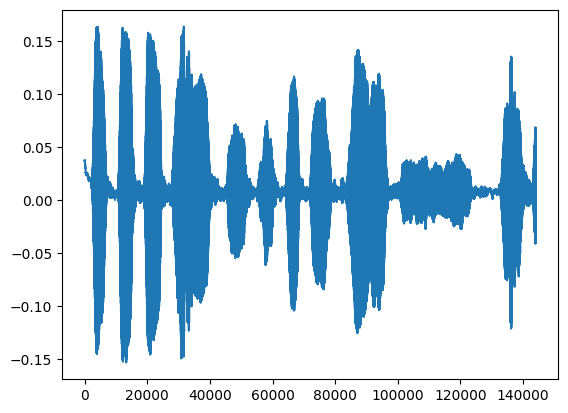

In [106]:
####################
# Lectura de audio #
####################

# Cargar el archivo CSV como un array de NumPy
fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
# fs_audio, wav_data = sio.wavfile.read('prueba psd.wav')
# fs_audio, wav_data = sio.wavfile.read('silbido.wav')

plt.figure()
plt.plot(wav_data)

En el grafico de arriba podemos observar una señal de audio.

## Calculo de PDS por Periodograma

In [107]:
#%% Calculo de Periodograma Señal ecg_one_lead

# Filtrado de frecuencia Nyquist
df = fs_ecg/N 
ff = np.arange(0,fs_ecg,df)
bfrec = ff <= fs_ecg/2 

# Calculo de Periodograma Señal ECG
ft_ecg_one_lead = np.fft.fft(ecg_one_lead, axis = 0 )/N
P_per = (1/N) * (np.abs(ft_ecg_one_lead)**2)

# Calculo de Periodograma Señal ppg
N1 = len(ppg)
df1 = fs_ppg/N1
ff1 = np.arange(0,fs_ppg,df1)
bfrec1 = ff1 <= fs_ppg/2 

ft_ppg = np.fft.fft(ppg)/N1
P_per_ppg = (1/N1) * (np.abs(ft_ppg)**2)

# Calculo de Periodograma Señal wav_audio
N2 = len(wav_data)
df2 = fs_audio/N2
ff2 = np.arange(0,fs_audio,df2)
bfrec2 = ff2 <= fs_audio/2 

ft_wav_data = np.fft.fft(wav_data)/N2
P_per_wav_data = (1/N2) * (np.abs(ft_wav_data)**2)

## Calculo de PDS por Welch

In [108]:
#%% Metodo Welch

f, Pxx_ecg_one_lead = signal.welch(ecg_one_lead, fs_ecg, nperseg=1024 , axis = 0)

f2, Pxx_ppg = signal.welch(ppg, fs_ppg, nperseg=1024 )

f3, Pxx_wav_data = signal.welch(wav_data, fs_audio, nperseg=1024 )

## Calculo de PDS por Blackman-Turkey

In [109]:
#%% Funcion de Blackman-Turkey

def per_smooth(x, win, M, n1=None, n2=None):
    x = np.asarray(x).flatten()

    if n1 is None and n2 is None:
        n1 = 1
        n2 = len(x)

    # Asegúrate de que hay suficientes datos
    if n2 - n1 < 2:
        raise ValueError("No hay suficientes datos para calcular la covarianza.")

     # Cálculo de la varianza
    R = np.var(x[n1:n2])

    # Crear un arreglo que repita R
    r = np.concatenate((np.repeat(R, M - 1), [R], np.repeat(R, M - 1)))

    M = 2 * M - 1

    w = np.ones(M)

    if win == 2:
        w = signal.windows.hamming(M)
    elif win == 3:
        w = signal.windows.hann(M)
    elif win == 4:
        w = signal.windows.bartlett(M)
    elif win == 5:
        w = signal.windows.blackman(M)

    r = r.T * w  # Multiplicación elemento a elemento

    Px = np.abs(fft(r, 1024))/n2 #Normalizo
    Px[0] = Px[1]

    return Px

In [110]:
#%% Metodo Blackman-Turney

win = 2 # Tipo de ventana (hamming)
M = 150  # Tamaño del modelo

Px_ecg = per_smooth(ecg_one_lead, win , M)
N_01 = len(Px_ecg)

Px_ppg = per_smooth(ppg, win , M)
N_02 = len(Px_ppg)

Px_audio = per_smooth(wav_data, win , M)
N_03 = len(Px_audio)

## Comparacion entre los distintos metodos de PDS

<Figure size 640x480 with 0 Axes>

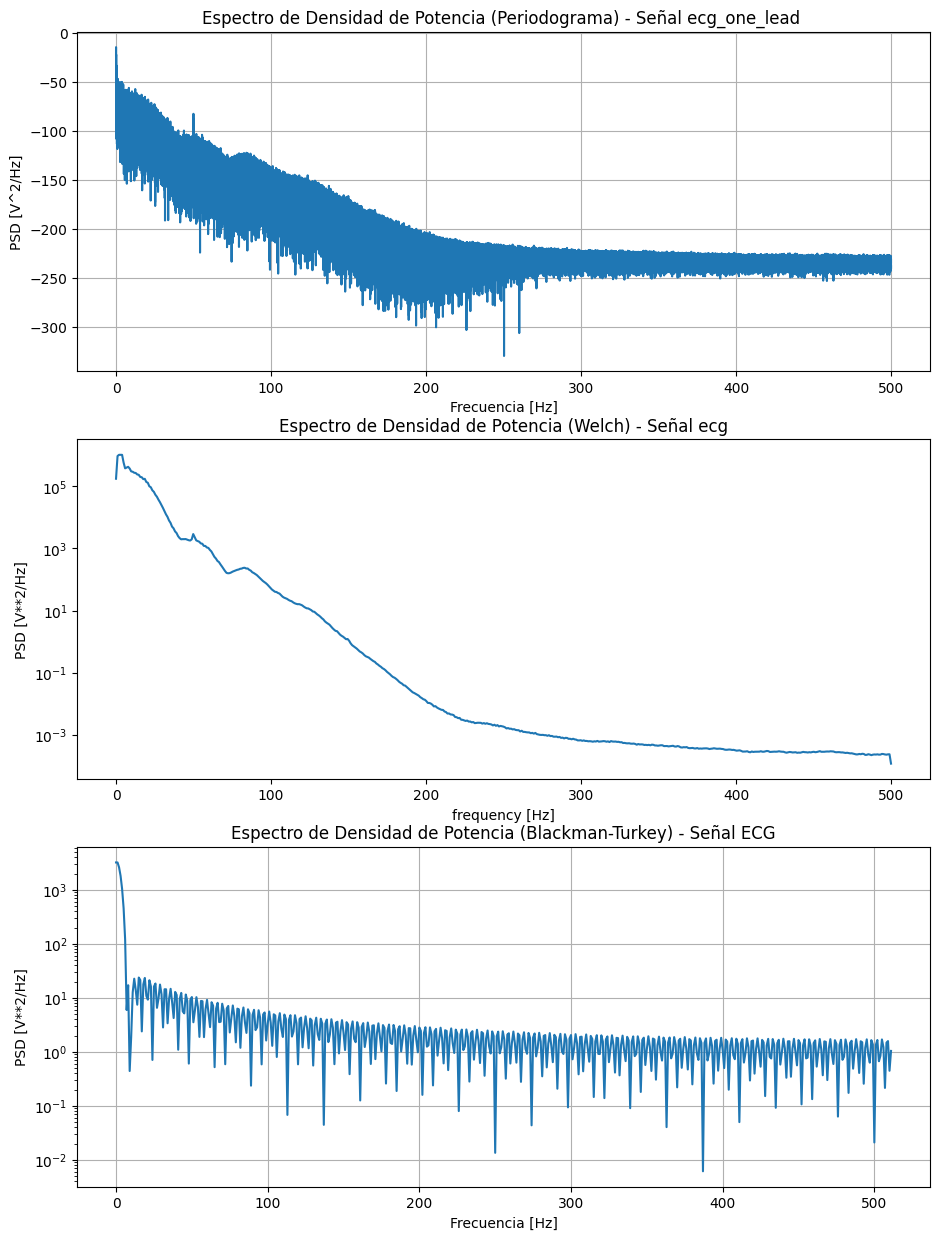

In [111]:
plt.figure()
plt.figure(figsize=(11, 15))  # Ajusta estos valores según lo que necesites
plt.subplot(311)
plt.plot(ff[bfrec],20* np.log10(np.abs(P_per[bfrec])))
plt.title('Espectro de Densidad de Potencia (Periodograma) - Señal ecg_one_lead ')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.grid()
plt.subplot(312)
plt.semilogy(f, Pxx_ecg_one_lead)
plt.title('Espectro de Densidad de Potencia (Welch) - Señal ecg')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.subplot(313)
plt.semilogy( Px_ecg[:N_01//2])  # Solo la mitad
plt.title('Espectro de Densidad de Potencia (Blackman-Turkey) - Señal ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()


En los graficos de arriba podemos observar los distintos PDS con los distintos metodos (Periodograma, Welch y Blackman-Turkey) de la señal ECG.
En dos primeros metodos podemos observar que tienen espectros similares. El espectro del Blackman-Turkey tiene una ventana Hamming.

<Figure size 640x480 with 0 Axes>

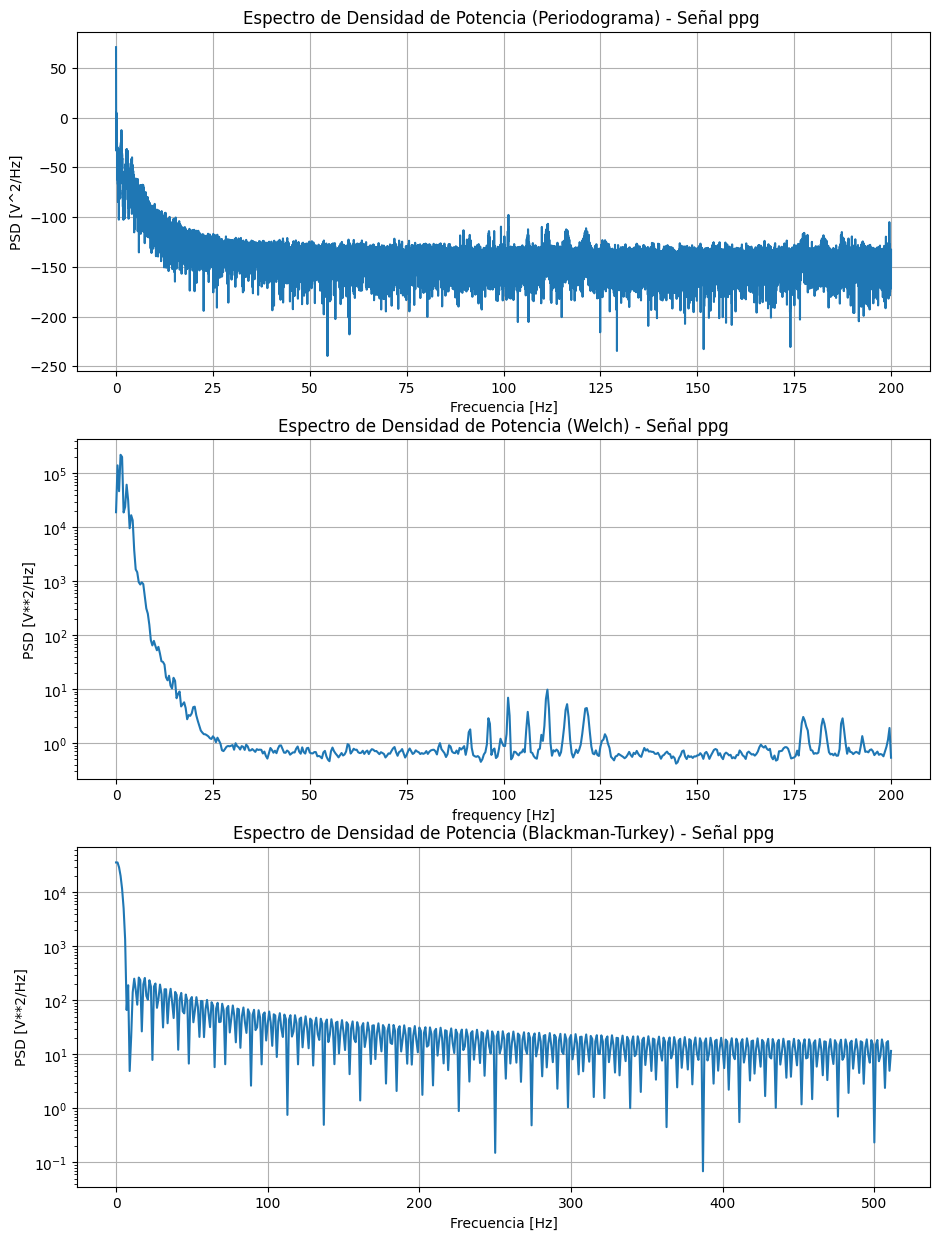

In [112]:
plt.figure()
plt.figure(figsize=(11, 15))  # Ajusta estos valores según lo que necesites
plt.subplot(311)
plt.plot(ff1[bfrec1],20 * np.log10(np.abs(P_per_ppg[bfrec1])))
plt.title('Espectro de Densidad de Potencia (Periodograma) - Señal ppg ')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.grid()
plt.subplot(312)
plt.semilogy(f2, Pxx_ppg)
plt.title('Espectro de Densidad de Potencia (Welch) - Señal ppg')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.subplot(313)
plt.semilogy( Px_ppg[:N_02//2])  # Solo la mitad
plt.title('Espectro de Densidad de Potencia (Blackman-Turkey) - Señal ppg')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()


En los graficos de arriba podemos observar el PDS con los distintos metodos (Periodograma, Welch y Blackman-Turkey) de la señal PPG.

<Figure size 640x480 with 0 Axes>

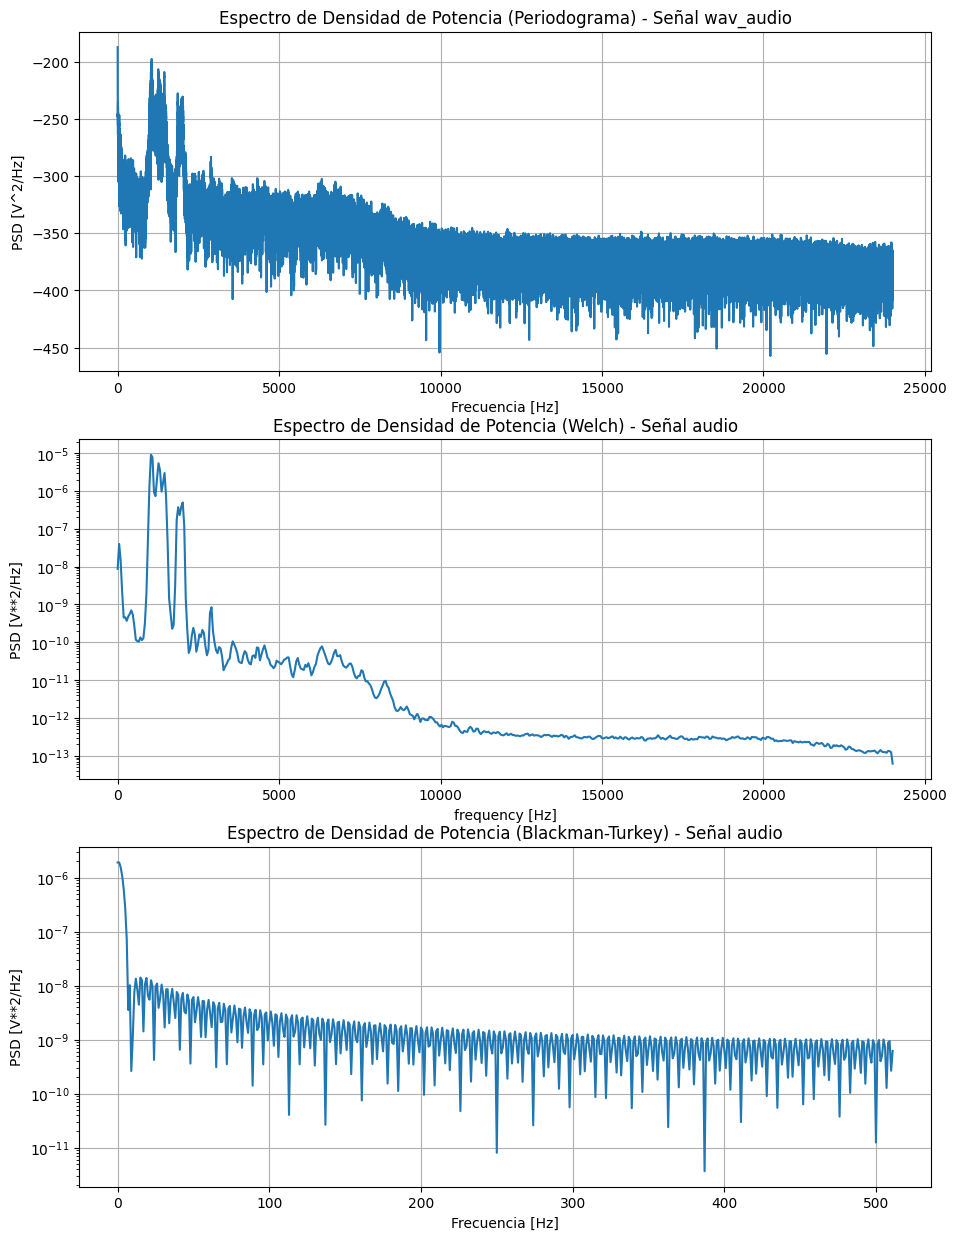

In [113]:
plt.figure()
plt.figure(figsize=(11, 15))  # Ajusta estos valores según lo que necesites
plt.subplot(311)
plt.plot(ff2[bfrec2],20 * np.log10(np.abs(P_per_wav_data[bfrec2])))
plt.title('Espectro de Densidad de Potencia (Periodograma) - Señal wav_audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.grid()
plt.subplot(312)
plt.semilogy(f3, Pxx_wav_data)
plt.title('Espectro de Densidad de Potencia (Welch) - Señal audio')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.subplot(313)
plt.semilogy( Px_audio[:N_03//2])  # Solo la mitad
plt.title('Espectro de Densidad de Potencia (Blackman-Turkey) - Señal audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.grid()
plt.show()

En los graficos de arriba podemos observar el PDS con los distintos metodos (Periodograma, Welch y Blackman-Turkey) de la señal de audio.

## Estimacion de Ancho de de Banda

In [114]:
N_1 = len(Pxx_ecg_one_lead)

# Calcular el rango de frecuencias
rango_f = f[-1] - f[0]  # Rango total de frecuencias de 0 a 500Hz en este caso, el f[-1] indica ultimo elemento.

# Calculo la energía total
energia_total = np.sum(Pxx_ecg_one_lead) * (rango_f / N_1)

umbral = 0.9
energia_umbral = umbral * energia_total
# Calculo de energia acumulada
energia_acumulada = np.cumsum(Pxx_ecg_one_lead) * (f[1] - f[0])
# Busco la frecuencia que supere la energia umbral
indices_ancho_banda = np.where(energia_acumulada >= energia_umbral)[0]
#En estos casos la frecuencia inferior es cero.
f_inferior = f[0]  # Frecuencia mínima
f_superior = f[indices_ancho_banda[0]]  # Frecuencia hasta el umbral
ancho_banda = f_superior - f_inferior
print(f'Ancho de banda: {ancho_banda} Hz')

Ancho de banda: 18.5546875 Hz


El ancho de banda de la señal de ECG es de 18.55Hz con un umbral de 90%, tambien probe con un umbral a 98% y se acerca a los 30Hz que se habian mensionado en clase.

In [115]:
N_2 = len(Pxx_ppg)

rango_f2 = f2[-1] - f2[0] 
 
energia_total = np.sum(Pxx_ppg) * (rango_f2 / N_2)

umbral = 0.9
energia_umbral = umbral * energia_total

energia_acumulada = np.cumsum(Pxx_ppg) * (f2[1] - f2[0])
indices_ancho_banda = np.where(energia_acumulada >= energia_umbral)[0]

f_inferior = f[0]  
f_superior = f[indices_ancho_banda[0]]
ancho_banda = f_superior - f_inferior
print(f'Ancho de banda: {ancho_banda} Hz')

Ancho de banda: 7.8125 Hz


El ancho de banda de la señal de pletismografía (PPG) es de 7.81Hz con un umbral del 90%, con un umbral del 98% se acerca a los 10Hz de ancho de banda.

In [116]:
N_3 = len(Pxx_wav_data)

rango_f3 = f3[-1] - f3[0] 

energia_total = np.sum(Pxx_wav_data) * (rango_f3 / N_3)

umbral = 0.9
energia_umbral = umbral * energia_total

energia_acumulada = np.cumsum(Pxx_wav_data) * (f3[1] - f3[0])
indices_ancho_banda = np.where(energia_acumulada >= energia_umbral)[0]

f_inferior = f[0] 
f_superior = f[indices_ancho_banda[0]] 
ancho_banda = f_superior - f_inferior
print(f'Ancho de banda: {ancho_banda} Hz')

Ancho de banda: 30.2734375 Hz


El ancho de banda de la señal de audio es de 30.27 Hz con un umbral del 90% , con un umbral del 98% se acerca a los 41Hz.